# PyUL Gradient Explorer

This document is not optimized for multithreaded computing.

In [5]:
## Simulation Parameters

gridlength = 8
resol = 64
MS = 7

DIVR = 5000# Number of Sample Points = 900k / DIVR. Simpson Integration Always Uses All.

NumSam = int(900000/DIVR)

if NumSam > resol:
    print('Generating',NumSam,'data points.')
else:
    raise ValueError('Not using enough sample points!')


Generating 180 data points.


In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


"""
Created on Tue Oct 27 11:19:20 2020

@author: ywan598

"""

import numpy as np
import numexpr as ne

import PyUltraLight_NBody_5 as PyUL

import matplotlib.pyplot as plt
import numexpr as ne


def simpsonFW(rho,x,NTer):
    
    
    rho = rho[0:NTer]
    dx = x[1] - x[0]
    x = x[0:NTer]
    

    N = len(rho)

    
    y = rho*x**2
    
    S = dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])
    return S


def GradientCompute(RAD,r,AnResol):
    
    xLog = np.zeros(int(899999/AnResol)+1)
    GLog = np.zeros(int(899999/AnResol)+1)

    for i in range(1,899999,AnResol):
    
        index = int((i-1)/AnResol)
        
        xLog[index] = r[i]
        print(r[i])

        GLog[index] = -4*np.pi*simpsonFW(RAD,r,i)/r[i]**2
    
    plt.figure(1)
    
    GLogM = -1*MS/xLog**2
    
    return xLog,GLog,GLogM



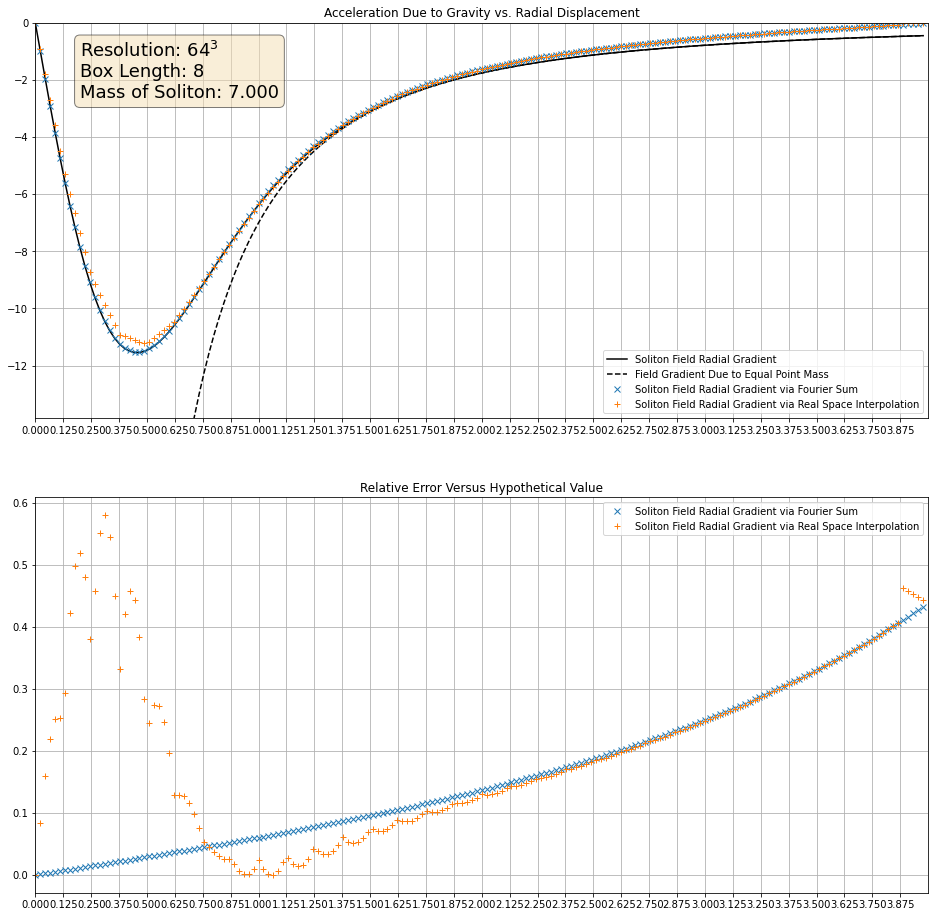

In [11]:
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(2, 2)
    
axNet = fig.add_subplot(gs[0, :])
axNet.set_title('Acceleration Due to Gravity vs. Radial Displacement')

axRel = fig.add_subplot(gs[1, :])
axRel.set_title('Relative Error Versus Hypothetical Value')


RAD = np.load('initial_f.npy')

RAD = np.array(RAD)


RAD = RAD[0:900000-1]

# This Scales RAD to Integrate to the Right Mass

alpha = (MS/3.883)**2

## Scaling to Real Space

r = np.linspace(0,gridlength/2,num = len(RAD),endpoint = False)

rhoModel = 0*r

for rIndex in range(len(r)):
    
    if (np.sqrt(alpha) * r[rIndex] <= 5.6):

        rhoModel[rIndex] = alpha * RAD[int(np.sqrt(alpha) * (r[rIndex] / 0.00001 + 1))]

        
rhoModel = ne.evaluate("real(abs(rhoModel)**2)")

Mass = 4*np.pi*simpsonFW(rhoModel, r,899999)


#Integrate!

xLog,GLog,GLogM = GradientCompute(rhoModel,r,DIVR)
    
axNet.plot(xLog,GLog,'k-',label = 'Soliton Field Radial Gradient')
axNet.plot(xLog,GLogM,'k--', label = 'Field Gradient Due to Equal Point Mass')

gridvec = np.linspace(-gridlength / 2.0, gridlength / 2.0, resol, endpoint=False)
    
xarray, yarray, zarray = np.meshgrid(
        gridvec, gridvec, gridvec,
        sparse=True, indexing='ij')

position = np.array([0,0,0])


ZEROS = np.zeros([resol,resol,resol])

RHOINIT = PyUL.initsoliton(ZEROS, xarray, yarray, zarray, position, alpha, RAD, 0.00001)

t0 = 0
velx = 0
vely = 0
velz = 0
beta = 2.454
phase = 0

PSIINIT = ne.evaluate("exp(1j*(alpha*beta*t0 + velx*xarray + vely*yarray + velz*zarray -0.5*(velx*velx+vely*vely+velz*velz)*t0  + phase))*RHOINIT")

RHOINIT = ne.evaluate("real(abs(PSIINIT)**2)")


## Fourier Stuff Again

rkvec = 2 * np.pi * np.fft.fftfreq(resol, gridlength / float(resol))
    
krealvec = 2 * np.pi * np.fft.rfftfreq(resol, gridlength / float(resol))

rkxarray, rkyarray, rkzarray = np.meshgrid(
    rkvec, rkvec, krealvec,
    sparse=True, indexing='ij'
)

rkarray2 = ne.evaluate("rkxarray**2+rkyarray**2+rkzarray**2")

WN = 2*np.pi*np.fft.fftfreq(resol, gridlength/(resol)) # 2pi Pre-multiplied

Kx,Ky,Kz = np.meshgrid(WN,WN,WN,sparse=True, indexing='ij',)

## Pass into NBody

phik = np.fft.rfftn(RHOINIT)

pi = np.pi

phik = ne.evaluate("-4*pi*phik/rkarray2")

phik[0, 0, 0] = 0


## Onward to FFT Interpolation Plot 
FieldFT = PyUL.FieldProcess(phik, gridlength, resol)

FSGradLog = np.zeros(len(xLog))

for i in range(len(xLog)):
    
    xLocal = xLog[i]
    Tp = np.array([xLocal,0,0])
    
    a = PyUL.FieldGradient(gridlength,Kx,Ky,Kz,FieldFT,Tp,resol)
    
    FSGradLog[i] = a[0]*-1
    
axNet.plot(xLog,FSGradLog,'x',label = 'Soliton Field Radial Gradient via Fourier Sum')


## Onward to Real Space Interpolation Plot

from scipy.interpolate import RegularGridInterpolator as RPI

phisp = np.fft.irfftn(phik)
    
phiGrad = np.gradient(phisp, gridvec,gridvec,gridvec, edge_order = 2)

phiGradX = phiGrad[0]

phiGradXI = RPI([gridvec,gridvec,gridvec],phiGradX,method = 'linear',bounds_error = False, fill_value = 0)

RPGradLog = np.zeros(len(xLog))

for i in range(len(xLog)):
    
    xLocal = xLog[i]
    Tp = np.array([xLocal,0,0])
    
    b = phiGradXI(Tp)
    
    RPGradLog[i] = b*-1
    
axNet.plot(xLog,RPGradLog,'+',label = 'Soliton Field Radial Gradient via Real Space Interpolation')
axNet.set_xticks(gridvec)
axNet.grid(which='both')

axNet.set_ylim(1.2*np.min(GLog),np.max(GLog))
axNet.set_xlim(0,gridlength/2)


axRel.set_xticks(gridvec)
axRel.grid(which='both')

axRel.plot(xLog,FSGradLog-GLog,'x',label = 'Soliton Field Radial Gradient via Fourier Sum')
axRel.plot(xLog,RPGradLog-GLog,'+',label = 'Soliton Field Radial Gradient via Real Space Interpolation')


axRel.set_xlim(0,gridlength/2)

from IPython.core.display import clear_output, display

clear_output()



axNet.legend()
axRel.legend()

textstr = '\n'.join((
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (gridlength, ),
    r'Mass of Soliton: %.3f' % (MS, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
axRel.text(0.05, 0.8, textstr, transform=axNet.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

plt.show()

In [ ]:
print(RPGradLog)